<a href="https://colab.research.google.com/github/theKirill/RecognitionOfRoadSigns/blob/master/CourseWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
import numpy as np

In [0]:
from skimage import io, transform

In [0]:
import matplotlib.pyplot as plt

In [0]:
import pandas as pd

In [0]:
from PIL import Image, ImageDraw

In [0]:
import cv2

In [10]:
import keras 

Using TensorFlow backend.


In [0]:
from keras.models import Sequential 

In [0]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [0]:
from keras.utils import to_categorical

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.models import load_model

In [0]:
from sklearn import model_selection   

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
from sklearn.utils import shuffle 

In [0]:
import seaborn as sn
from sklearn.metrics import classification_report

In [0]:
import matplotlib.patches as patches

In [0]:
import keras_metrics

In [0]:
!pip install keras_metrics

In [0]:
IMG_SIZE = 32 #размер изображения

In [0]:
CLASSES_COUNT = 30

In [0]:
class RoadSignLocalization:
  def __init__(self):
    self.__path_images = "" #путь, где хранятся изображения
    self.__extension_images = ".ppm" #расширения изображений
    
  @property
  def path_images(self):
    return self.__path_images

  @path_images.setter
  def path_images(self, path):
    self.__path_images = path

  @property
  def extension_images(self):
    return self.__path_images

  @path_images.setter
  def extension_images(self, extension):
    self.__extension_images = extension

  # Получение всех содержащихся обучающих изображений знаков и номеров классов этих знаков
  def get_all_train_images(self):
    self.__path_images = "drive/My Drive/Images_Train/"
    images_of_signs = []
    classes_of_signs = []

    for root, dirs, files in os.walk(self.__path_images):
      sign_class = root[-2:]
      if sign_class.isdigit():#у каждого класса знака читаем csv-файл
        name_csv = root + "/GT-000" + sign_class + ".csv"
        file_csv = pd.read_csv(name_csv, delimiter = ';')
        #Берём углы знаков для каждого изображения из csv файла
        x_left = file_csv['Roi.X1']
        y_left = file_csv['Roi.Y1']
        x_right = file_csv['Roi.X2']
        y_right = file_csv['Roi.Y2']
        i = 0
        for file in files: #каждое изображение обрезаем по области знака, масштабируем до 32*32
          if file[-4:] == self.__extension_images:
            self.get_sign_area(root +'/', file, y_left[i], y_right[i], x_left[i], x_right[i])
            self.scale_img(root + '/', file[:-4] + "_new.ppm")
            images_of_signs.append(io.imread(root + '/' + file[:-4] + "_new.ppm"))#добавляем в массив изображений
            classes_of_signs.append(int(sign_class))#заносим информацию о классе знака
            i+=1
    
    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0
    classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT)

    return images_of_signs, classes_of_signs

    # Получение всех содержащихся обучающих изображений знаков и номеров классов этих знаков
  def get_all_train_images_(self):
    self.__path_images = "drive/My Drive/Images_Train/"
    images_of_signs = []
    classes_of_signs = []

    for root, dirs, files in os.walk(self.__path_images):
      sign_class = root[-2:]
      if sign_class.isdigit():
        print(sign_class)
        for file in files:
          if file[-8:] == "_new.ppm":
            images_of_signs.append(io.imread(root + '/' + file))#добавляем в массив изображений
            classes_of_signs.append(int(sign_class))#заносим информацию о классе знака
    
    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0
    classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT)

    return images_of_signs, classes_of_signs

  # Получение всех тестовых изображений знаков и номеров классов этих знаков
  def get_all_test_images(self):
    self.__path_images = "drive/My Drive/Images_Test/"
    images_of_signs = []
    classes_of_signs = []

    file_csv = pd.read_csv(self.__path_images + 'GT-final_test.csv', delimiter=';') #читаем информацию о каждом изображении
    #Берём углы и классы знаков для каждого изображения из csv файла
    images_names = file_csv['Filename']
    x_left = file_csv['Roi.X1']
    y_left = file_csv['Roi.Y1']
    x_right = file_csv['Roi.X2']
    y_right = file_csv['Roi.Y2']
    classes_of_signs = file_csv["ClassId"]

    for i in range(images_names.size):#каждое изображение обрезаем по области знака, масштабируем до 32*32
      self.get_sign_area(self.__path_images, images_names[i], y_left[i], y_right[i], x_left[i], x_right[i])
      self.scale_img(self.__path_images, images_names[i][:-4] + "_new.ppm")
      images_of_signs.append(io.imread(self.__path_images + images_names[i][:-4] + "_new.ppm"))

    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0
    classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT)

    return images_of_signs, classes_of_signs

    # Получение всех тестовых изображений знаков и номеров классов этих знаков
  def get_all_test_images_(self):
    self.__path_images = "drive/My Drive/Images_Test/"
    images_of_signs = []
    classes_of_signs = []

    file_csv = pd.read_csv(self.__path_images + 'GT-final_test.csv', delimiter=';') #читаем информацию о каждом изображении
    classes_of_signs = file_csv["ClassId"]
    images_names = file_csv['Filename']

    for i in range(images_names.size):#каждое изображение обрезаем по области знака, масштабируем до 32*32
      images_of_signs.append(io.imread(self.__path_images + images_names[i][:-4] + "_new.ppm"))

    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0

    return images_of_signs, classes_of_signs

  # Получение всех изображений знаков для предсказания классов
  def get_all_signs_for_predict(self):
    self.__path_images = "drive/My Drive/BadSigns/"
    new_root = "drive/My Drive/GoodSigns/"
    all_signs_of_images = []
    signs_of_current_image = []
    all_signs_rects = []
    sign_rect_of_current_image = []
    names_of_images = []
    ind_file = 0

    for root, dirs, files in os.walk(self.__path_images):
      for file in files:
        for i in range(2):
          if (i == 0):
            names_of_images.append(file)
            signs_of_current_image = np.array(signs_of_current_image, dtype = "float32") / 255.0 
            all_signs_of_images.append(signs_of_current_image)
            all_signs_rects.append(sign_rect_of_current_image)
            sign_rect_of_current_image = []
            signs_of_current_image = []

          img = io.imread(root + file)
          hsv = self.to_hsv(img)

          if i == 0:
            mask = self.binarization_red(hsv)
          else:
            mask = self.binarization_blue(hsv)
         
            #mask = self.binarization_yellow(hsv)

          mask = self.canny(mask)

          contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
          #contours = contours[1] #берём только массив контуров

          if len(contours) > 0:
            contours = sorted(contours, key = cv2.contourArea, reverse = True)#сортируем контуры по площади

            contour_ind = 0
            (x,y,w,h) = cv2.boundingRect(contours[contour_ind]) #вырезаем прямоугольную область самого большого контура, получаем координаты его верхнего левого угла и ширину/высоту

            while (w > 70 and h > 70 and contour_ind < len(contours)):
               # обрезаем знак по прямоугольнику, масштабируем
              self.get_sign_area(root, file, y, y + h, x, x + w, new_root)      
              self.scale_img(new_root, file)
              signs_of_current_image.append(io.imread(new_root + file))
              sign_rect_of_current_image.append([x,y,w,h])

              contour_ind += 1

              if contour_ind < len(contours):
                (x,y,w,h) = cv2.boundingRect(contours[contour_ind]) #вырезаем прямоугольную область самого большого контура, получаем координаты его верхнего левого угла и ширину/высоту

          # else:
          #   sign_rect_of_current_image.append([])

    signs_of_current_image = np.array(signs_of_current_image, dtype = "float32") / 255.0 
    all_signs_of_images.append(signs_of_current_image)
    all_signs_rects.append(sign_rect_of_current_image)
    names_of_images = np.array(names_of_images)

    return all_signs_of_images, all_signs_rects, names_of_images

  #"Вырезаем" область знака
  def get_sign_area(self, root, name_img, y_left, y_right, x_left, x_right, new_root = ""):
    img = cv2.imread(root + name_img)
    # Обрезаем изображение по прямоугольнику
    area_sign = img[y_left:y_right, x_left:x_right]

    if new_root == "":
      cv2.imwrite(root + name_img[:-4] + "_new." + name_img[-3:], area_sign)
    else:
      cv2.imwrite(new_root + name_img, area_sign)

  #Масштабируем изображение до 32*32
  def scale_img(self, root, name_img):
    basewidth = 300
    img = Image.open(root + name_img)

    draw = ImageDraw.Draw(img)  # Создаем инструмент для рисования.
    width = img.size[0]  # Определяем ширину.
    height = img.size[1]  # Определяем высоту.
    pix = img.load()  # Выгружаем значения пикселей.

    wpercent = (basewidth / float(img.size[0]))
    # Масштабируем до нужного размера
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img.save(root + name_img)

  # перевод изображения в HSV-формат
  def to_hsv(self, img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # Ищем с помощью детектора Canny края объектов
  def canny(self, img):
    return cv2.Canny(img, 100, 200, apertureSize = 7)
  
  # бинаризация изображения по красному цвету
  def binarization_red(self, img):
    return cv2.inRange(img, (117, 100, 45), (255, 255, 255))
  
  # бинаризация изображения по синему цвету
  def binarization_blue(self, img):
    return cv2.inRange(img, (0, 174, 40), (25, 255, 255))#cv2.inRange(img, (117,100,45), (255,255,255))#cv2.inRange(sss, (0, 225, 0), (50, 255, 255))

  # бинаризация изображения по жёлтому цвету
  def binarization_yellow(self, img):
    return cv2.inRange(img, (50, 0, 100), (100, 255, 245))#cv2.inRange(img, (117,100,45), (255,255,255))#cv2.inRange(sss, (0, 225, 0), (50, 255, 255))

In [0]:
localization = RoadSignLocalization()

In [0]:
all_, rects, names = localization.get_all_signs_for_predict()

[1]


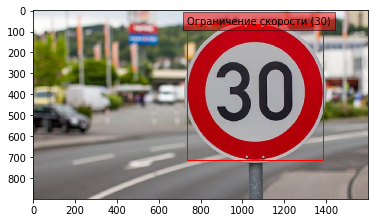

[0]


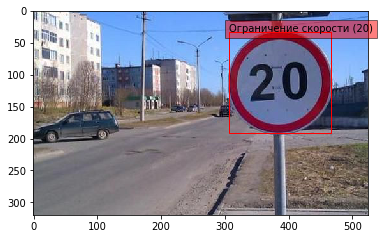

[13 25]


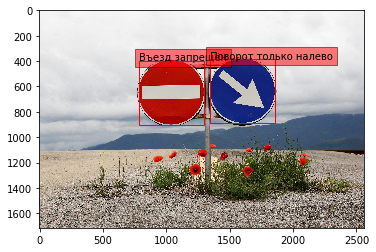

[12]


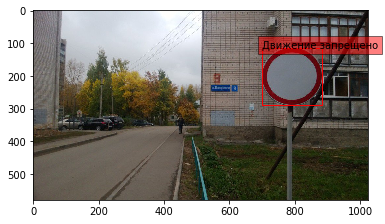

[22]


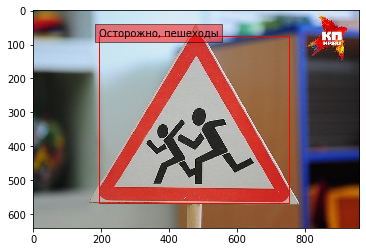

[10 27]


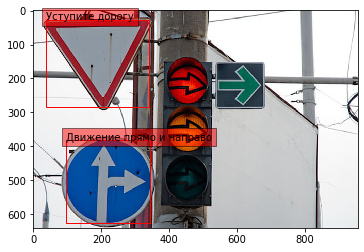

[2]


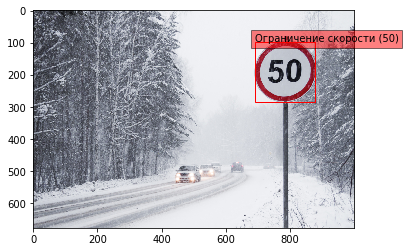

[16 21]


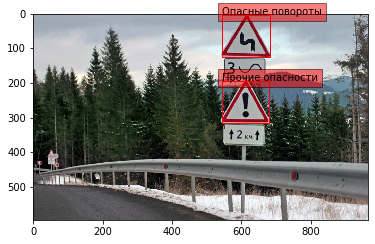

[5]


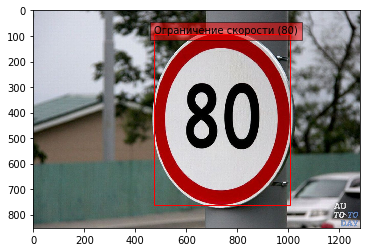

[10]


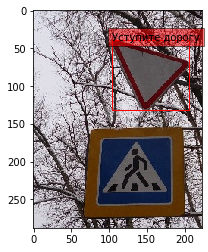

[8]


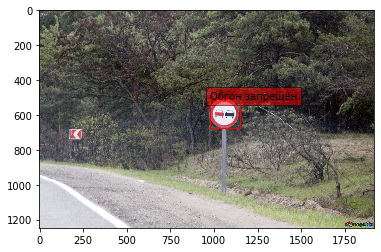

[15]


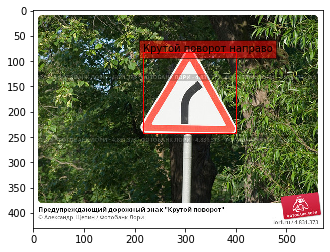

[10 29]


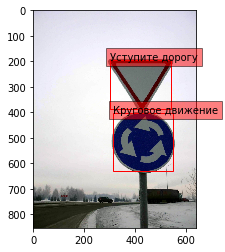

[11]


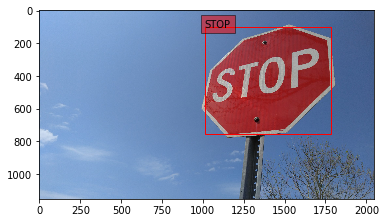

[25]


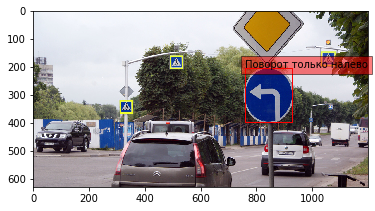

[11 10 13 24]


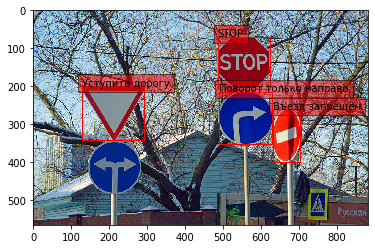

[8]


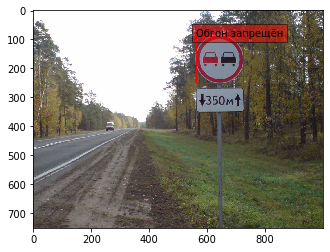

[10 10]


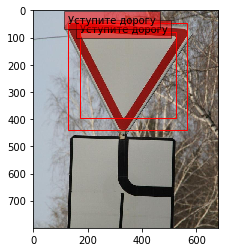

[10]


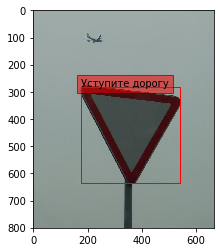

[10 29]


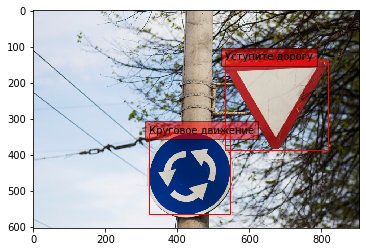

[29]


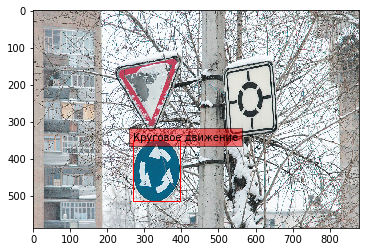

[18]


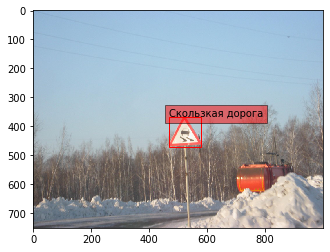

[20]


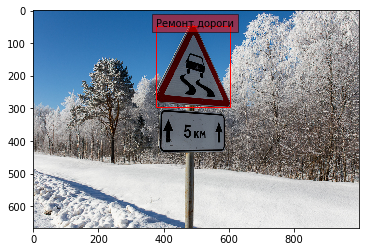

[10 25]


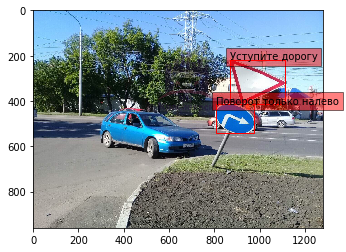

[13]


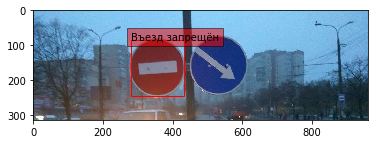

[ 8 18]


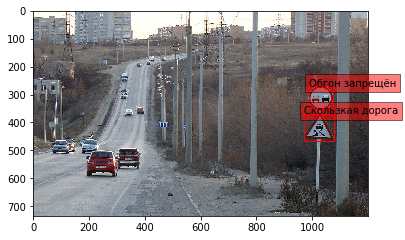

[29]


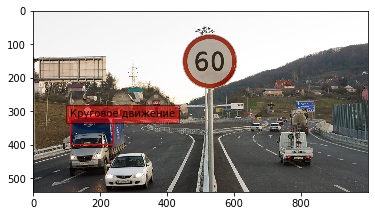

[10  2 17 26]


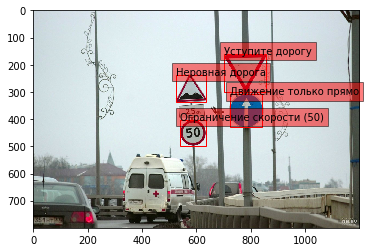

[8]


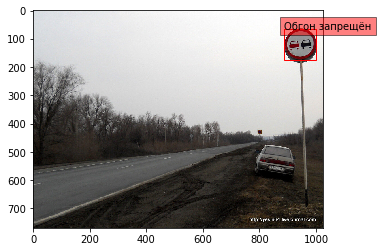

[12]


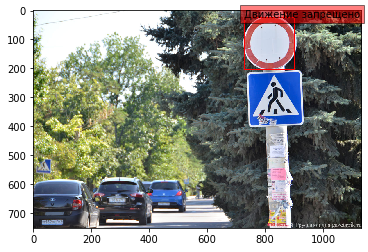

[8]


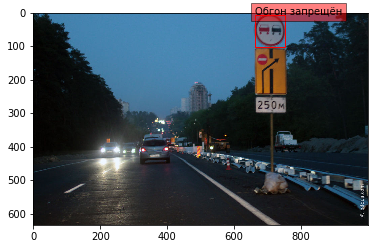

In [549]:
classification.predict_classes_on_images(all_, rects, names)

In [0]:
class RoadSignClassification:
  X_train = []
  y_train = []    
  X_predict = []
  names_of_images = []

  def __init__(self):
    self.__EPOCHS_COUNT = 50
    self.__BATCH_SIZE = 200
    self.__KERNEL = (3, 3)
    self.__model = None
    self.__X_test = []
    self.__y_test = []
    self.__history = []
    self.__names_classes = ['Ограничение скорости (20)','Ограничение скорости (30)','Ограничение скорости (50)',
                 'Ограничение скорости (60)','Ограничение скорости (70)','Ограничение скорости (80)',
                 'Ограничение скорости (100)','Ограничение скорости (120)','Обгон запрещён',
                 'Главная дорога','Уступите дорогу','STOP','Движение запрещено','Въезд запрещён',
                 'Крутой поворот налево','Крутой поворот направо','Опасные повороты','Неровная дорога',
                 'Скользкая дорога','Сужение дороги справа','Ремонт дороги','Прочие опасности','Осторожно, пешеходы',
                 'Отмена всех ограничений','Поворот только направо','Поворот только налево','Движение только прямо',
                 'Движение прямо и направо','Движение прямо и налево','Круговое движение']

  @property
  def EPOCHS_COUNT(self):
    return self.__EPOCHS_COUNT

  @EPOCHS_COUNT.setter
  def EPOCHS_COUNT(self, count):
    if (count > 0):
      self.__EPOCHS_COUNT = count

  @property
  def BATCH_SIZE(self):
    return self.__BATCH_SIZE

  @BATCH_SIZE.setter
  def BATCH_SIZE(self, size):
    if (size > 0):
      self.__BATCH_SIZE = size

  # Создание модели
  def get_model(self):
    model = Sequential() 
    model.add(Conv2D(32, self.__KERNEL, input_shape = (IMG_SIZE, IMG_SIZE, 3), padding = 'same', activation = 'relu'))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, self.__KERNEL, padding = 'same', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, self.__KERNEL, padding = 'same', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(CLASSES_COUNT, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [keras_metrics.categorical_f1_score()])
  
    return model

  # обучаем модель
  def fit_model(self, X_train = [], y_train = [], retrain = False):
    if int(retrain) == 0:
      self.__model = None
      self.__model = self.get_model()
      
    if (len(X_train) == 0):
      X_train = self.X_train
      y_train = self.y_train

    self.__history = self.__model.fit(X_train, y_train, epochs = self.__EPOCHS_COUNT, batch_size = self.__BATCH_SIZE, validation_split = 0.2,
         callbacks = [ModelCheckpoint('drive/My Drive/Models/modelBest_december_best.h5', save_best_only = True)]) 
    
    return self.__history

  def graphic_acc(self, w = 25, h = 10):
    x = range(self.__EPOCHS_COUNT)
    plt.figure(figsize = (w, h))
    plt.grid(True)

    plt.plot(x, 
            self.__history.history['f1_score'], 
            'bo-', 
            label = 'Train f1_score')
    
    plt.plot(x, 
            self.__history.history['val_f1_score'],
            'ro-',
            label = 'Validation f1_score')
    
    plt.xlabel('Epochs')
    plt.ylabel('F1_score')
    
    plt.legend(loc = 'lower right')

  def graphic_losses(self, w = 25, h = 10):
    x = range(self.__EPOCHS_COUNT)
    plt.figure(figsize = (w, h))
    plt.grid(True)

    plt.plot(x, 
            self.__history.history['loss'], 
            'bo-', 
            label = 'Train losses')
    
    plt.plot(x, 
            self.__history.history['val_loss'],
            'ro-',
            label = 'Validation losses')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend(loc = 'upper right')

  # кроссвалидация
  def cross_valid(self, X_train, y_train):
    models_histories = []
    n_folds = 5
    scores = []

    kf = model_selection.KFold(n_splits = n_folds) # Разбиение на 5 непересекающихся частей

    for train, test in kf.split(X_train, y_train):# В train, test - индексы элементов для обучения и теста соответственно
      models_histories.append(self.fit_model(X_train[train], y_train[train]))# Обучение на тренировочных данных
      scores.append(self.evaluate(X_train[test], y_train[test]))# Тестирование полученной модели

    print(scores)
    print("Средняя точность: {}".format(np.mean(scores)))

  def evaluate(self, X_test, y_test):
    score = self.__model.evaluate(X_test, y_test, batch_size = self.__BATCH_SIZE)

    print(u'Оценка точности модели: {}'.format(score[1]))

    return score[1]

  # тестируем сеть на тестовых изображениях из базы
  def test_model(self, X_test, y_test):
    self.__model = load_model('drive/My Drive/Models/modelBest03_11(11).h5')#modelBest03_11(11)
    self.__model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    prediction = self.__model.predict_classes(X_test)

    # y_test = y_test.tolist()
    # y_test_ = []
    # for i in range(len(y_test)):
    #   y_test_.append(y_test[i].index(1))

    print("test_model: {}".format(np.sum(prediction == y_test) / np.size(prediction)))
    self.reports(prediction, y_test)

  # подготавливаем изображения для теста
  def prepocess_test_images(self):
    localization = RoadSignLocalization()
    self.__X_test, self.__y_test = localization.get_all_test_images_()

  # получаем ранее обученную модель  
  def get_trained_model(self):
    self.__model = load_model('drive/My Drive/Models/modelBest03_11(11).h5')#modelBest03_11(11)
    self.__model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  # предсказываем классы знаков на своих изображениях
  def predict_classes_on_images(self, X_predict, rects, names_of_images):
    #self.prepocess_images_for_predict()

    if (self.__model == None):
      self.get_trained_model()

    for i in range(1, len(X_predict)):
      if len(X_predict[i]) > 0:
        prediction = self.__model.predict_classes(X_predict[i])
        
        img = io.imread("drive/My Drive/BadSigns/" + names_of_images[i - 1])
        self.highlight_signs_on_image(img, rects[i], prediction)
        #print("Изображение '{}' содержит знак - {}".format(names_of_images[i], self.__names_classes[prediction[j]]))

  def highlight_signs_on_image(self, img, rects, prediction):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    for i in range(len(prediction)):
      if len(rects[i]) > 0:
        x, y, w, h = rects[i]
        rect = patches.Rectangle((x, y), w, h, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        plt.text(x,y, self.__names_classes[prediction[i]], bbox = dict(facecolor = 'red', alpha = 0.5))
    
    plt.show()

  # подготавливаем изображения для предсказания классов
  #def prepocess_images_for_predict(self):
  # Сравнение по метрикам, построение матрицы ошибок
  def reports(self, prediction, y_test):
    print(classification_report(y_test, prediction, target_names = self.__names_classes))

    prediction = self.transform_names(prediction)
    y_test = self.transform_names(np.array(y_test))

    data = {'prediction': prediction,
        'actual':    y_test
        }

    df = pd.DataFrame(data, columns = ['actual','prediction'])
    confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['Actual'], colnames = ['Predicted'])
    plt.figure(figsize = (30, 10))
    sn.heatmap(confusion_matrix, annot = True, cmap = "Greys")

    plt.savefig('drive/My Drive/Models/matrix.jpg')

  # Преобразование номеров классов в названия классов
  def transform_names(self, prediction):
    answers = []

    for i in range(prediction.shape[0]):
      answers.append(self.__names_classes[prediction[i]])

    return answers

In [0]:
classification = RoadSignClassification()

In [381]:
all_[19]

array([[[[0.9764706 , 1.        , 0.91764706],
         [0.9372549 , 1.        , 0.90588236],
         [0.92156863, 1.        , 0.89411765],
         ...,
         [0.5254902 , 0.2901961 , 0.1882353 ],
         [0.59607846, 0.29803923, 0.23529412],
         [0.7058824 , 0.3372549 , 0.30588236]],

        [[1.        , 0.7176471 , 0.72156864],
         [0.8235294 , 0.6156863 , 0.58431375],
         [0.75686276, 0.6117647 , 0.5411765 ],
         ...,
         [0.5803922 , 0.23529412, 0.1882353 ],
         [0.5882353 , 0.20784314, 0.18431373],
         [0.68235296, 0.26666668, 0.26666668]],

        [[0.7490196 , 0.16078432, 0.26666668],
         [0.61960787, 0.10588235, 0.1764706 ],
         [0.53333336, 0.12156863, 0.14117648],
         ...,
         [0.64705884, 0.23137255, 0.23137255],
         [0.57254905, 0.18039216, 0.1882353 ],
         [0.6862745 , 0.3254902 , 0.32941177]],

        ...,

        [[0.88235295, 0.8627451 , 0.8901961 ],
         [0.8745098 , 0.8666667 , 0.8784314 ]

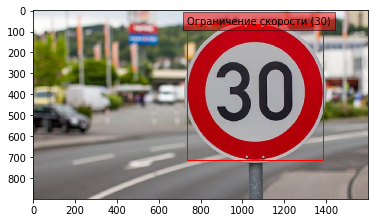

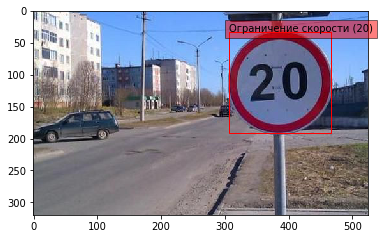

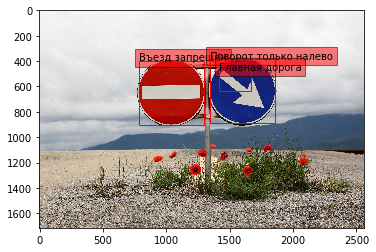

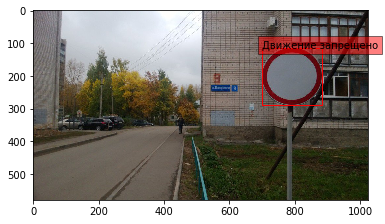

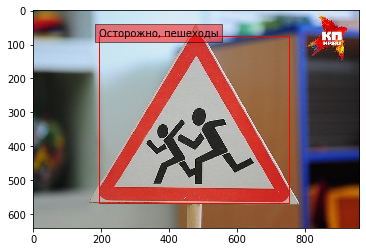

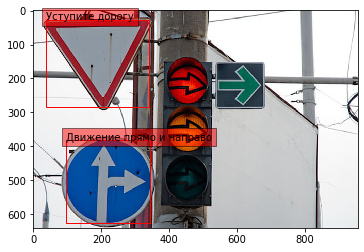

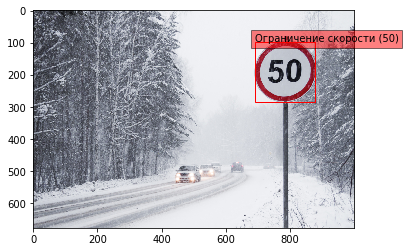

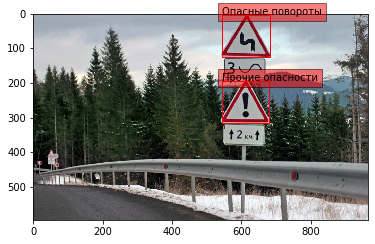

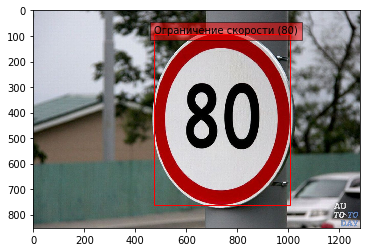

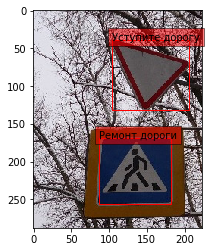

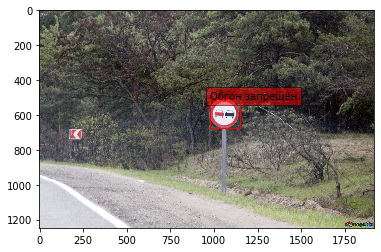

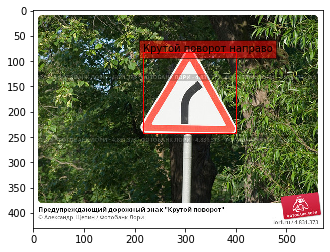

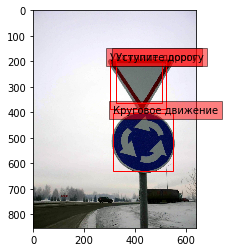

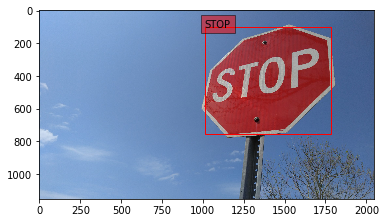

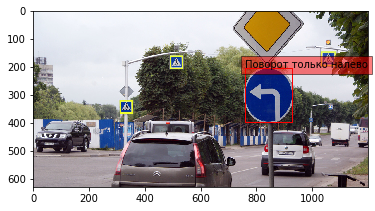

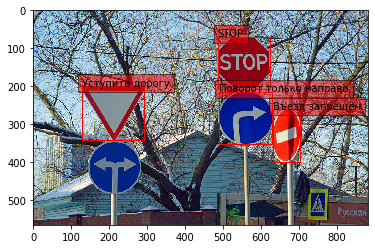

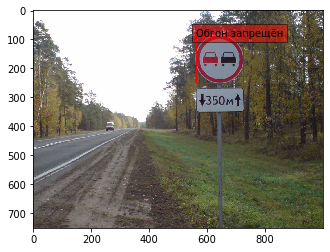

In [424]:
classification.predict_classes_on_images(all_, rects, names)

In [0]:
classification.fit_model(X_train_, y_train_)

NameError: ignored

In [0]:
classification.graphic1(15,10)

In [0]:
classification.graphic2(15,10)

In [0]:
X_test_, y_test_ = shuffle(X_test, y_test) 

test_model: 0.9777056277056277
                            precision    recall  f1-score   support

 Ограничение скорости (20)       1.00      1.00      1.00        60
 Ограничение скорости (30)       0.98      0.99      0.99       720
 Ограничение скорости (50)       0.99      0.97      0.98       750
 Ограничение скорости (60)       0.95      0.96      0.95       450
 Ограничение скорости (70)       1.00      0.98      0.99       660
 Ограничение скорости (80)       0.95      0.97      0.96       630
Ограничение скорости (100)       0.97      1.00      0.99       450
Ограничение скорости (120)       1.00      0.98      0.99       450
            Обгон запрещён       1.00      0.97      0.98       480
            Главная дорога       0.96      0.98      0.97       690
           Уступите дорогу       1.00      0.99      1.00       720
                      STOP       1.00      1.00      1.00       270
        Движение запрещено       0.99      1.00      0.99       210
            Въез

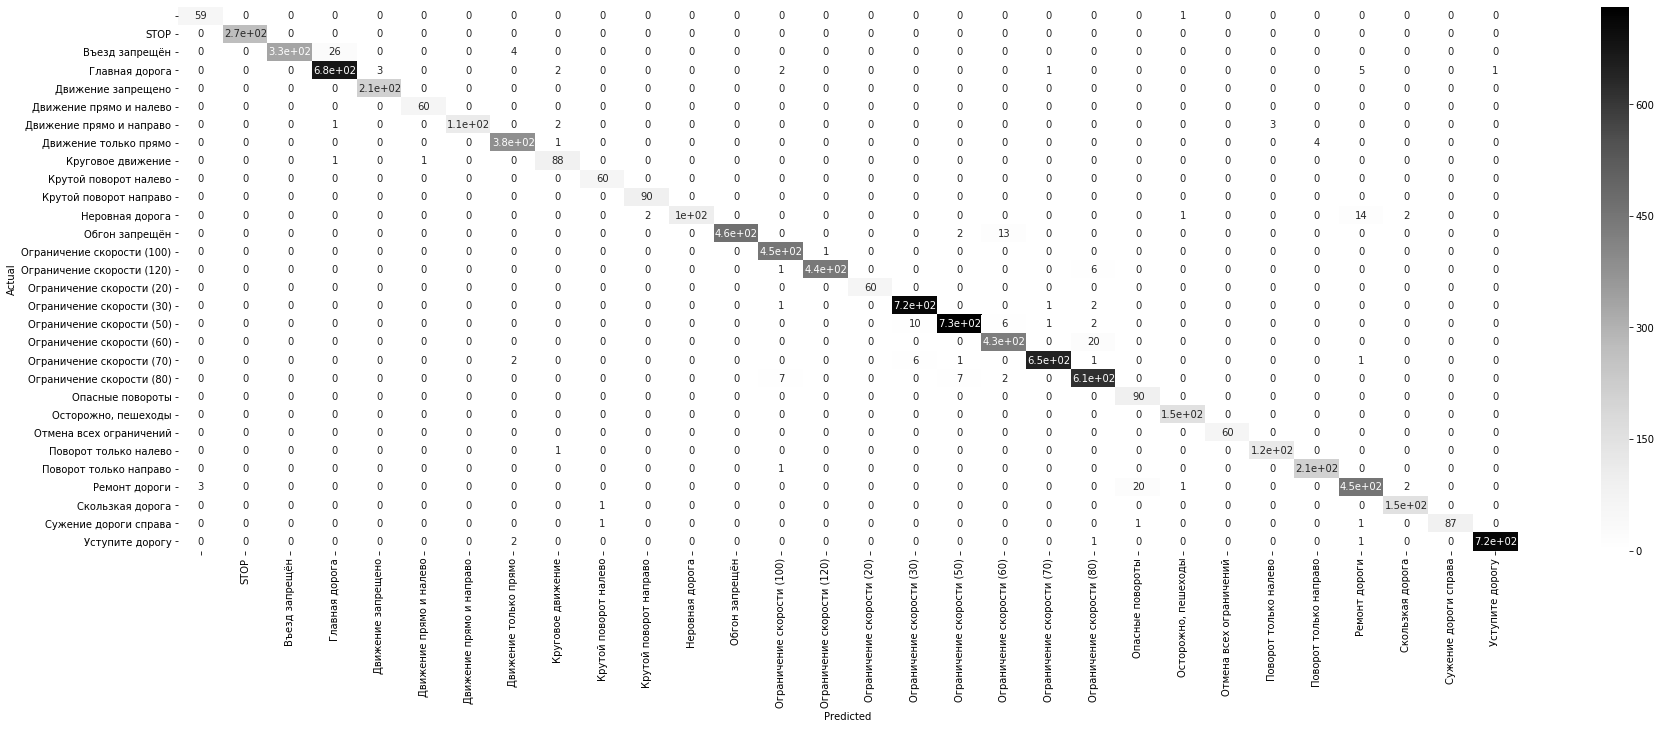

In [0]:
classification.test_model(X_test, y_test)

In [0]:
classification.cross_valid(X_train_, y_train_)

Train on 18488 samples, validate on 4623 samples
Epoch 1/55
18488/18488 [==============================] - 3s 154us/step - loss: 2.7544 - f1_score: 0.0000e+00 - val_loss: 2.0357 - val_f1_score: 0.0000e+00
Epoch 2/55
18488/18488 [==============================] - 1s 64us/step - loss: 1.8027 - f1_score: 0.0423 - val_loss: 1.4204 - val_f1_score: 0.1290
Epoch 3/55
18488/18488 [==============================] - 1s 62us/step - loss: 1.3849 - f1_score: 0.1006 - val_loss: 1.1398 - val_f1_score: 0.0000e+00
Epoch 4/55
18488/18488 [==============================] - 1s 63us/step - loss: 1.1283 - f1_score: 0.1605 - val_loss: 0.8833 - val_f1_score: 0.5000
Epoch 5/55
18488/18488 [==============================] - 1s 63us/step - loss: 0.9394 - f1_score: 0.3617 - val_loss: 0.7353 - val_f1_score: 0.6190
Epoch 6/55
18488/18488 [==============================] - 1s 64us/step - loss: 0.7737 - f1_score: 0.5024 - val_loss: 0.6115 - val_f1_score: 0.6087
Epoch 7/55
18488/18488 [==============================] 

KeyboardInterrupt: ignored

In [0]:
X_train_, y_train_ = shuffle(X_train, y_train) 

In [0]:
X_train__, y_train__ = shuffle(X_train, y_train) 

In [0]:
classification.fit_model(X_train=X_train, y_train=y_train)

Train on 23111 samples, validate on 5778 samples
Epoch 1/1
23111/23111 [==============================] - 4s 189us/step - loss: 2.2763 - acc: 0.2618 - val_loss: 8.5502 - val_acc: 0.0190


In [0]:
localization = RoadSignLocalization()
X_train, y_train = localization.get_all_train_images_()

00
28
23
01
14
02
03
10
04
05
09
06
13
08
07
29
27
26
25
24
12
11
15
16
17
18
19
21
22
20


In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
kf = model_selection.KFold(n_splits = 3)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
classification.X_predict, classification.names_of_images = localization.get_all_signs_for_predict()

In [0]:
classification.fit_model()

00


KeyboardInterrupt: ignored